In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, ifftshift

In [2]:
class LaserBeamShaper:
    def __init__(self, spatial_freq, n_elements, intensity_lb, intensity_ub, aperture_support=None):
        """
        Laser beam shaping using iterative projections (POCS algorithm)

        Parameters:
        spatial_freq      : Spatial frequency domain (1D array) [rad/m]
        n_elements        : Number of phase control elements
        intensity_lb      : Lower intensity bound (amplitude) at focal plane
        intensity_ub      : Upper intensity bound (amplitude) at focal plane
        aperture_support  : Binary mask defining active aperture region
        """
        self.k        = spatial_freq  # Spatial frequencies
        self.M        = n_elements    # Number of control elements
        self.lb       = intensity_lb  # Lower amplitude constraint in the focal plane
        self.ub       = intensity_ub  # Upper amplitude constraint in the focal plane
        self.support  = np.ones_like(spatial_freq) if aperture_support is None else aperture_support

        # Propagation parameters (simplified Fraunhofer diffraction)
        self.delta_k            = spatial_freq[1] - spatial_freq[0]
        self.element_positions  = np.linspace(-np.pi, np.pi, n_elements)

    def apply_intensity_constraints(self, focal_field):
        """Enforce intensity constraints in focal plane while preserving phase"""
        amplitude       = np.abs(focal_field)
        phase           = np.exp(1j * np.angle(focal_field))

        # Apply constraints
        constrained_amp = np.clip(amplitude, self.lb, self.ub)

        return constrained_amp * phase

    def compute_focal_field(self, aperture_field):
        """Compute focal plane field from aperture field (FFT propagation - the focal plane is in the far-field)"""
        return fftshift(fft(ifftshift(aperture_field)))

    def compute_aperture_field(self, focal_field):
        """Compute aperture field from focal field (inverse FFT - the focal plane is in the far-field)"""
        return fftshift(ifft(ifftshift(focal_field)))

    def optimize_beam(self, max_iter=5000, tol=1e-12, verbose=True):
        """Run POCS optimization for beam shaping"""
        # Initialize with lower intensity constraint
        aperture_field  = fft(ifftshift(self.lb)) * self.support
        focal_field     = self.compute_focal_field(aperture_field)

        # Normalize to focal plane maximum
        norm_factor     = np.max(np.abs(focal_field))
        aperture_field  /= norm_factor
        focal_field     /= norm_factor

        err_history = []
        for iter in range(max_iter):
            # Store current state
            prev_field        = np.copy(aperture_field)

            # Apply focal plane constraints
            constrained_focal = self.apply_intensity_constraints(focal_field)

            # Propagate back to aperture
            aperture_field    = self.compute_aperture_field(constrained_focal)

            # Apply aperture support constraint
            aperture_field    *= self.support

            # Propagate to focal plane
            focal_field       = self.compute_focal_field(aperture_field)

            # Normalize
            focal_field       /= np.max(np.abs(focal_field))

            # Calculate convergence metric
            delta             = np.linalg.norm(aperture_field - prev_field) / np.linalg.norm(prev_field)
            err_history.append(delta)

            if verbose and (iter % 500 == 0):
                print(f"Iteration {iter}: Δ = {delta:.3e}")

            if delta < tol:
                if verbose:
                    print(f"Converged after {iter} iterations")
                break

        self.aperture_field = aperture_field
        self.focal_field    = focal_field
        self.error_history  = np.array(err_history)
        return aperture_field, focal_field, err_history

    def visualize_results(self):
        """Generate comprehensive beam shaping diagnostics"""
        # Create figure grid
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(3, 2)

        # Focal plane intensity comparison
        ax1 = fig.add_subplot(gs[0, :])
        focal_intensity = np.abs(self.focal_field)**2
        focal_db = 10 * np.log10(focal_intensity / np.max(focal_intensity))
        ax1.plot(self.k, 20 * np.log10(self.lb), 'r--', lw=2, label='Lower constraint')
        ax1.plot(self.k, 20 * np.log10(self.ub), 'g--', lw=2, label='Upper constraint')
        ax1.plot(self.k, focal_db, 'b-', label='Optimized beam')
        ax1.set_xlabel('Spatial Frequency (rad/m)')
        ax1.set_ylabel('Normalized Intensity (dB)')
        ax1.set_title('Focal Plane Intensity Profile')
        ax1.legend()
        ax1.grid(True)
        ax1.set_ylim(-60, 5)

        # Aperture modulation
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(np.abs(self.aperture_field), 'b.-', label='Amplitude')
        ax2.set_xlabel('Element Index')
        ax2.set_ylabel('Amplitude')
        ax2.set_title('Aperture Amplitude Modulation')
        ax2.grid(True)

        ax3 = fig.add_subplot(gs[1, 1])
        ax3.plot(np.angle(self.aperture_field), 'r.-', label='Phase')
        ax3.set_xlabel('Element Index')
        ax3.set_ylabel('Phase (rad)')
        ax3.set_title('Aperture Phase Modulation')
        ax3.grid(True)

        # Convergence history
        ax4 = fig.add_subplot(gs[2, 0])
        ax4.semilogy(self.error_history)
        ax4.set_xlabel('Iteration')
        ax4.set_ylabel('Relative Change')
        ax4.set_title('Optimization Convergence')
        ax4.grid(True)

        # Focal plane phase
        ax5 = fig.add_subplot(gs[2, 1])
        ax5.plot(self.k, np.angle(self.focal_field), 'm-')
        ax5.set_xlabel('Spatial Frequency (rad/m)')
        ax5.set_ylabel('Phase (rad)')
        ax5.set_title('Focal Plane Phase Distribution')
        ax5.grid(True)

        plt.tight_layout()
        plt.show()

Iteration 0: Δ = 1.706e+00
Iteration 500: Δ = 2.696e-04
Iteration 1000: Δ = 1.850e-04
Iteration 1500: Δ = 1.276e-04
Iteration 2000: Δ = 9.333e-05
Iteration 2500: Δ = 7.159e-05
Iteration 3000: Δ = 5.685e-05
Iteration 3500: Δ = 4.631e-05
Iteration 4000: Δ = 3.848e-05
Iteration 4500: Δ = 3.253e-05


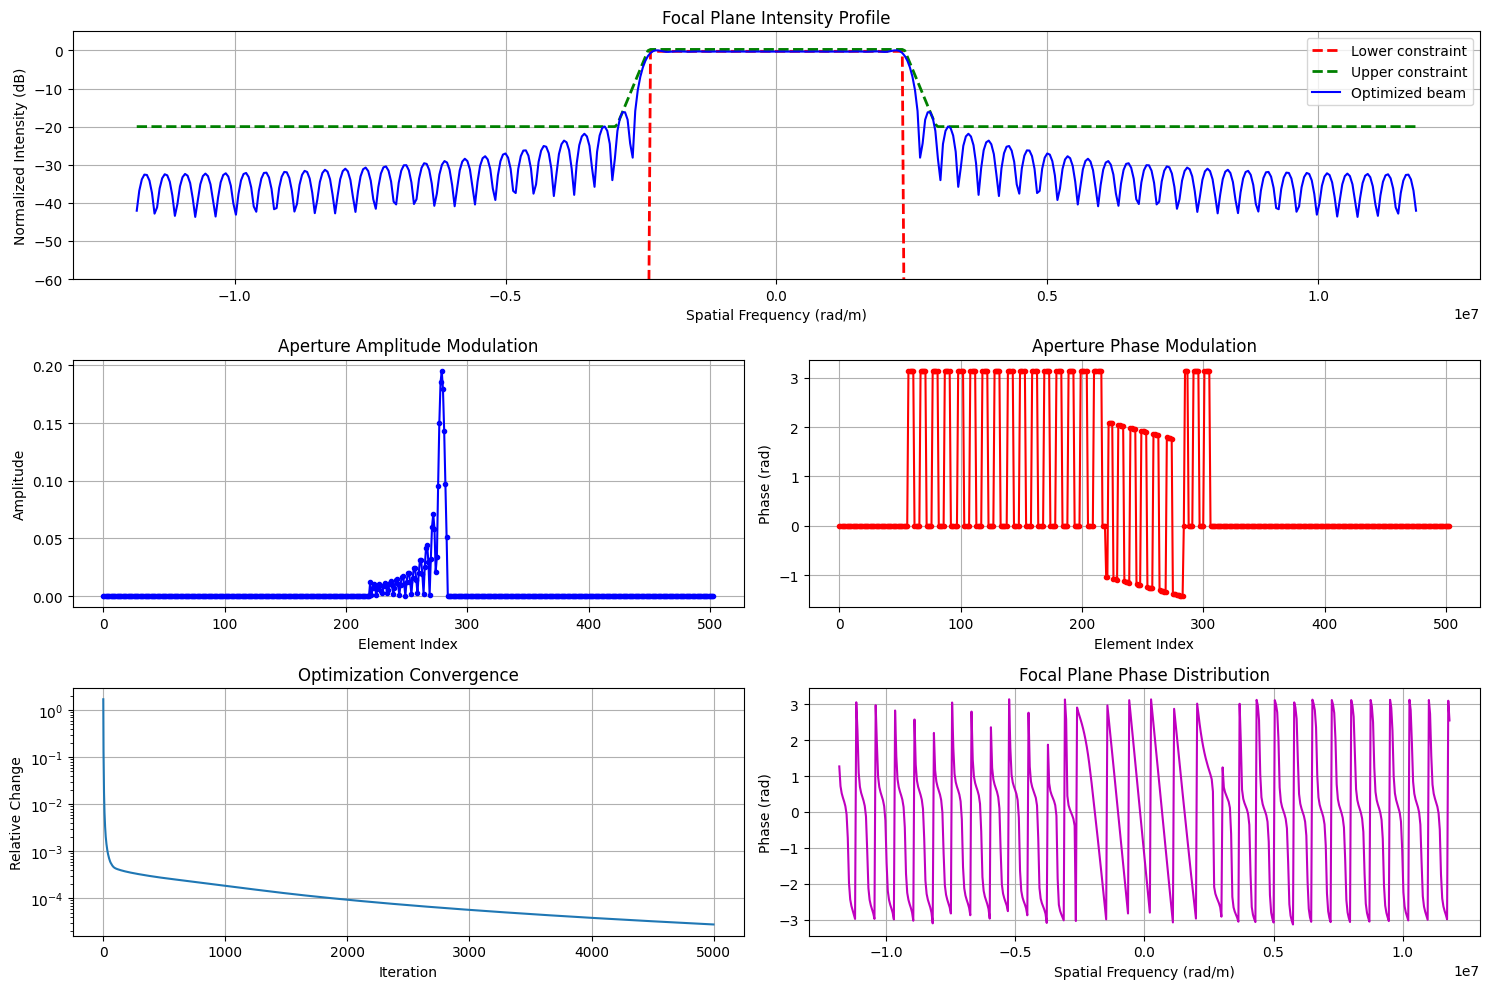


Beam shaping metrics:
Main lobe uniformity: 0.0099
Peak sidelobe level: -1.5 dB


In [3]:
# ======================
# Example: Laser Shaping
# ======================
if __name__ == "__main__":
    # Optical system parameters
    WAVELENGTH        = 532e-9    # Green laser (532 nm)
    APERTURE_SIZE     = 5e-3      # 5mm aperture
    N_ELEMENTS        = 64        # Phase control elements

    # Spatial frequency domain (k-space)
    k_max             = 2*np.pi / WAVELENGTH
    k                 = np.linspace(-k_max, k_max, 8 * (N_ELEMENTS - 1))

    # Create top-hat intensity profile with controlled sidelobes
    main_lobe_width   = k_max / 5  # Desired main lobe width
    transition_width  = k_max / 20

    # --- dB specs
    main_ripple_db    = 0.25    # ±0.25 dB in main lobe
    ub_outside_db     = -20.0   # –20 dB floor outside
    lb_floor_db       = -100.0  # –100 dB floor everywhere else

    # convert to linear
    main_hi_lin       = 10**( main_ripple_db / 20)
    main_lo_lin       = 10**(-main_ripple_db / 20)
    ub_outside_lin    = 10**(ub_outside_db   / 20)
    lb_floor_lin      = 10**(lb_floor_db     / 20)

    # allocate masks
    intensity_lb      = lb_floor_lin    * np.ones_like(k)
    intensity_ub      = ub_outside_lin  * np.ones_like(k)

    # main‐lobe region
    main = np.abs(k) < main_lobe_width
    intensity_lb[main] = main_lo_lin
    intensity_ub[main] = main_hi_lin

    # transition band: |k| ∈ [main_lobe_width, main_lobe_width+transition_width]
    t = (np.abs(k) - main_lobe_width) / transition_width
    t = np.clip(t, 0, 1)

    # only upper mask transitions
    ub_db = main_ripple_db + (ub_outside_db - main_ripple_db) * t
    ub_lin = 10**(ub_db/20)

    in_trans = (t > 0) & (t < 1)
    intensity_ub[in_trans] = ub_lin[in_trans]
    # Aperture support (physical constraint)
    support = np.zeros_like(k)
    support[len(k)//2 - N_ELEMENTS//2 : len(k)//2 + N_ELEMENTS//2] = 1

    # Create and run beam shaper
    shaper = LaserBeamShaper(spatial_freq = k, n_elements = N_ELEMENTS, intensity_lb = intensity_lb, intensity_ub = intensity_ub, aperture_support = support)

    # Run optimization
    aperture_field, focal_field, errors = shaper.optimize_beam(max_iter = 5000, tol = 1e-14, verbose = True)

    # Visualize results
    shaper.visualize_results()

    # Additional diagnostics
    print("\nBeam shaping metrics:")
    print(f"Main lobe uniformity: {np.std(np.abs(focal_field[main])):.4f}")
    print(f"Peak sidelobe level: {10*np.log10(np.max(np.abs(focal_field[~main])**2)):.1f} dB")